In [8]:
pip install geopandas rasterio rasterstats numpy pandas


Note: you may need to restart the kernel to use updated packages.


In [9]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import numpy as np
import pandas as pd
from shapely.geometry import Point

In [10]:
lsoa = gpd.read_file("Lower_layer_Super_Output_Areas_(December_2021)_Boundaries_EW_BFC_(V10).shp")
lsoa = lsoa.to_crs("EPSG:4326")

In [11]:
# Read population raster
with rasterio.open("gbr_ppp_2020_constrained.tif") as src:
    data = src.read(1)
    transform = src.transform

In [12]:
# Extract non-null pixels from raster
rows, cols = np.where(data > 0)
xs, ys = rasterio.transform.xy(transform, rows, cols)
pop_values = data[rows, cols]

In [13]:
# Create a point GeoDataFrame
points = gpd.GeoDataFrame({
    "population": pop_values,
    "geometry": [Point(x, y) for x, y in zip(xs, ys)]
}, crs="EPSG:4326")

In [14]:
# Spatial intersection to match LSOA
joined = gpd.sjoin(points, lsoa, how="inner", predicate="within")

In [15]:
print(joined.columns)


Index(['population', 'geometry', 'index_right', 'FID', 'LSOA21CD', 'LSOA21NM',
       'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LONG', 'Shape__Are',
       'Shape__Len', 'GlobalID'],
      dtype='object')


In [17]:
# Calculate the population-weighted centroid for each LSOA
results = []
for lsoa_id, group in joined.groupby("LSOA21CD"):  # 修改为你的LSOA唯一标识字段
    total_pop = group["population"].sum()
    if total_pop > 0:
        x_c = (group.geometry.x * group.population).sum() / total_pop
        y_c = (group.geometry.y * group.population).sum() / total_pop
        results.append({
            "LSOA21CD": lsoa_id,
            "pop_centroid_x": x_c,
            "pop_centroid_y": y_c
        })

In [ ]:
df = pd.DataFrame(results)
df.to_csv("lsoa_population_centroids.csv", index=False)

In [ ]:
pip install geopandas shapely pandas

In [18]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

In [19]:
# Read LSOA boundaries
lsoa = gpd.read_file("Lower_layer_Super_Output_Areas_(December_2021)_Boundaries_EW_BFC_(V10).shp")
lsoa = lsoa.to_crs("EPSG:4326")  # Unify coordinate reference systems


In [20]:
# Read population centroid CSV and convert to GeoDataFrame
centroids = pd.read_csv("lsoa_population_centroids.csv")
geometry = [Point(xy) for xy in zip(centroids.pop_centroid_x, centroids.pop_centroid_y)]
centroids_gdf = gpd.GeoDataFrame(centroids, geometry=geometry, crs="EPSG:4326")

In [21]:
# Spatial intersection check
joined = gpd.sjoin(centroids_gdf, lsoa, how="left", predicate="within")

In [22]:
# Check which points are not matched to any LSOA
unmatched = joined[joined['index_right'].isna()]

In [23]:
# Print results
print(f"Total number of population centroid points:{len(centroids_gdf)}")
print(f"Number of points not located within any LSOA:{len(unmatched)}")

Total number of population centroid points:35671
Number of points not located within any LSOA:7


In [24]:
print(lsoa.columns)

Index(['FID', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT',
       'LONG', 'Shape__Are', 'Shape__Len', 'GlobalID', 'geometry'],
      dtype='object')


c:\Users\zhouzhou\anaconda3\envs\urbsim\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zhouzhou\anaconda3\envs\urbsim\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zhouzhou\anaconda3\envs\urbsim\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zhouzhou\anaconda3\envs\urbsim\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


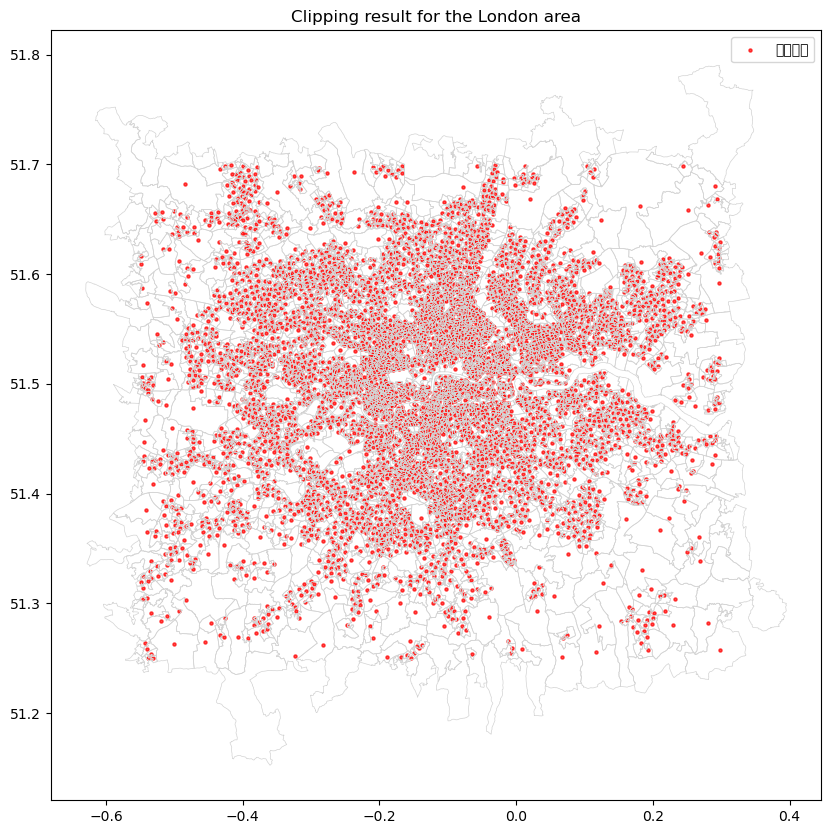

In [25]:
# Approximate latitude and longitude range of London
lon_min, lon_max = -0.55, 0.3
lat_min, lat_max = 51.25, 51.7

# Clip LSOA
lsoa_london = lsoa.cx[lon_min:lon_max, lat_min:lat_max]

# Clip population centroids
centroids_london = centroids_gdf.cx[lon_min:lon_max, lat_min:lat_max]

# plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
lsoa_london.boundary.plot(ax=ax, edgecolor='lightgrey', linewidth=0.5)
centroids_london.plot(ax=ax, color='red', markersize=5, alpha=0.7, label='人口重心')
plt.title("Clipping result for the London area")
plt.legend()
plt.show()